/projects/genomic-ml/da2343/cs685/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/projects/genomic-ml/da2343/cs685/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


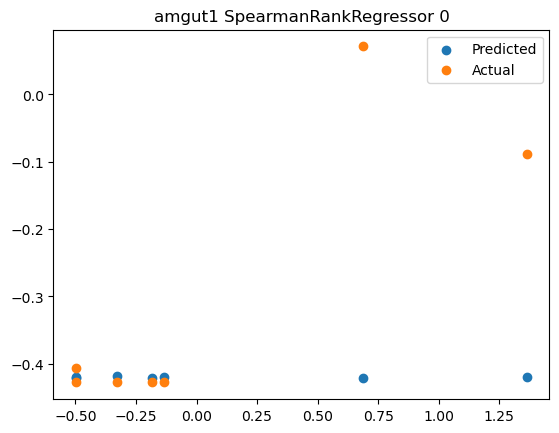

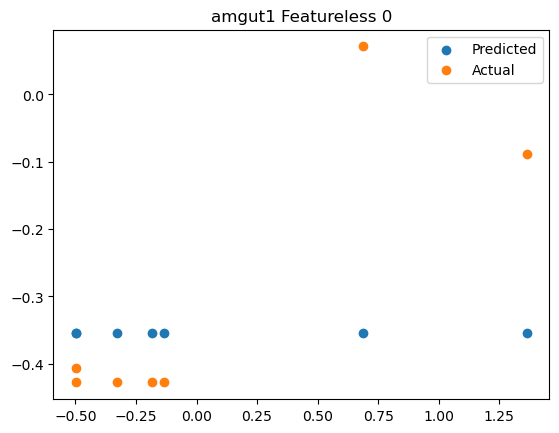

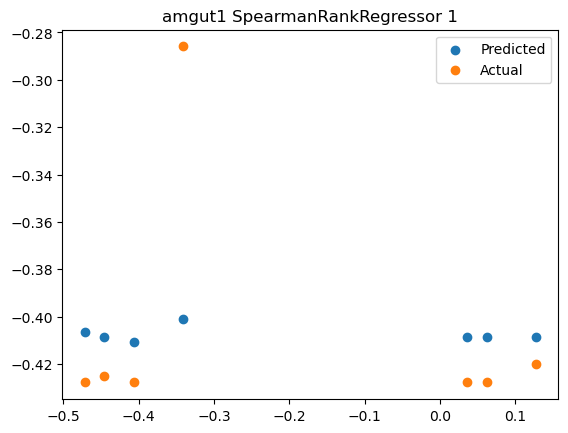

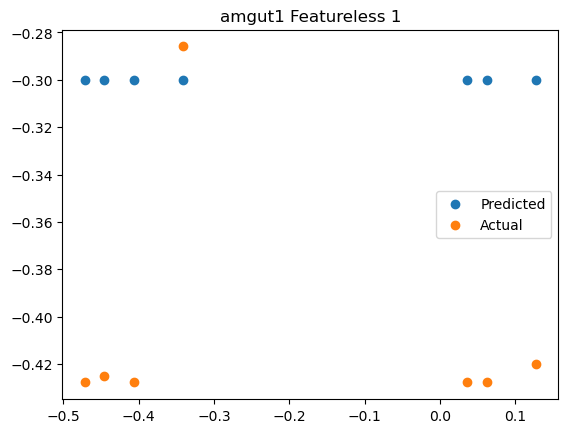

/projects/genomic-ml/da2343/cs685/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/projects/genomic-ml/da2343/cs685/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


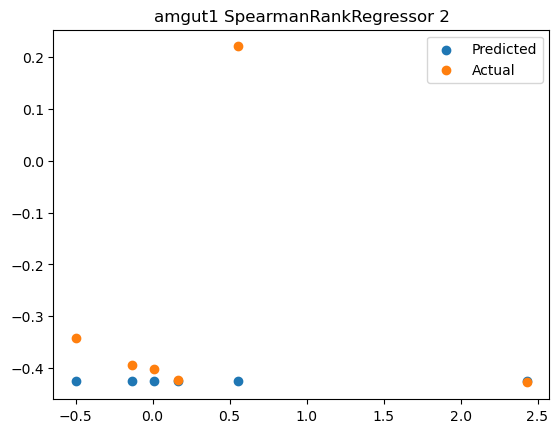

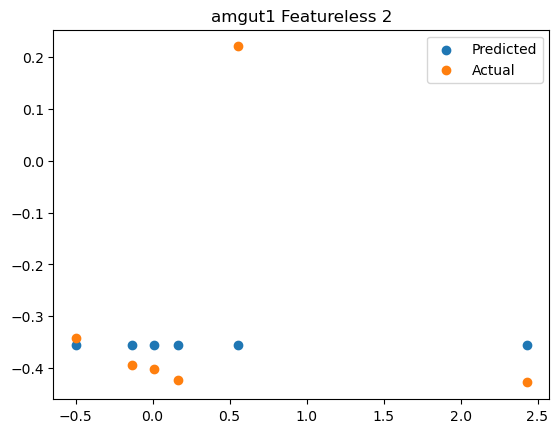

   Mean Squared Error  FoldID  # of Samples Dataset  \
0            0.050214       0            20  amgut1   
0            0.039403       0            20  amgut1   
0            0.002151       1            20  amgut1   
0            0.013624       1            20  amgut1   
0            0.070844       2            20  amgut1   
0            0.057615       2            20  amgut1   

   Index of Predicted Column              Algorithm  
0                          0  SpearmanRankRegressor  
0                          0            Featureless  
0                          0  SpearmanRankRegressor  
0                          0            Featureless  
0                          0  SpearmanRankRegressor  
0                          0            Featureless  


In [1]:
from scipy.optimize import minimize
import pandas as pd
import numpy as np
from datetime import date
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LassoCV, BayesianRidge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import multivariate_normal
import sys
import os
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
import scipy.stats as ss
from scipy import stats
from scipy.stats import spearmanr
from scipy import interpolate
from sklearn.covariance import GraphicalLassoCV, ledoit_wolf
from sklearn.preprocessing import *
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt


np.set_printoptions(threshold=sys.maxsize)


class Featureless:
    def fit(self, X, y):
        self.mean = np.mean(y)

    def predict(self, X):
        test_features = X
        test_nrow, test_ncol = test_features.shape
        return np.repeat(self.mean, test_nrow)

class MyPearsonRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, threshold=0.0):
        self.threshold = threshold

    def fit(self, X, y):
        slope_list = []
        intercept_list = []
        for index_col in range(X.shape[1]):
            X_col = X[:, index_col]
            calc_slope, calc_intercept = self.find_model_params(X_col, y)
            slope_list.append(calc_slope)
            intercept_list.append(calc_intercept)
        # Find the mean of the gradients and intercepts
        self.slope_list = slope_list
        self.intercept_list = intercept_list
        return self

    def find_model_params(self, X_col, y_col):
        calc_cor = np.corrcoef(X_col, y_col)[0, 1]
        # If the correlation is greater than the threshold, then calculate the gradient and intercept
        if abs(calc_cor) > self.threshold:
            calc_slope = calc_cor * np.std(y_col) / np.std(X_col)
            calc_intercept = np.mean(y_col) - calc_slope * np.mean(X_col)
        else:
            calc_slope = None
            calc_intercept = None
        return calc_slope, calc_intercept

    def predict(self, X):
        pred_y_list = []
        for index_col in range(X.shape[1]):
            X_col = X[:, index_col]
            # use the average of the slope_list as the default slope
            filtered_slope_list = [x for x in self.slope_list if x is not None]
            mean_filtered_slope = np.mean(filtered_slope_list) if len(
                filtered_slope_list) > 0 else 0
            calc_slope = mean_filtered_slope if self.slope_list[
                index_col] is None else self.slope_list[index_col]

            filtered_intercept_list = [
                x for x in self.intercept_list if x is not None]
            mean_filtered_intercept = np.mean(filtered_intercept_list) if len(
                filtered_intercept_list) > 0 else 0
            calc_intercept = mean_filtered_intercept if self.intercept_list[
                index_col] is None else self.intercept_list[index_col]

            calc_y = calc_slope * X_col + calc_intercept
            pred_y_list.append(calc_y)
        # Find the mean of the predicted y values
        pred_y = np.mean(pred_y_list, axis=0)
        return pred_y

class GuassianGraphicalMethod:
    def fit(self, X, y):
        full_train_data = np.concatenate((y[:, None], X), axis=1)
        # full_train_data_transformed = PowerTransformer().fit_transform(full_train_data)

        ledoit_wolf_cov = ledoit_wolf(full_train_data)[0]
        ledoit_wolf_prec = np.linalg.inv(ledoit_wolf_cov)

        model = GraphicalLassoCV().fit(full_train_data)
        self.covariance = model.covariance_

        # Calculate the sample covariance matrix
        covariance = np.cov(full_train_data, rowvar=False)

        # self.precision = ledoit_wolf_prec
        self.precision = model.precision_
        # self.precision = np.linalg.inv(covariance)
        return self

    def predict(self, X):
        # test_data_transformed = PowerTransformer().fit_transform(X)
        test_data_scaled = StandardScaler().fit_transform(X)
        precision_first_val = self.precision[0, 0]

        # check if covariance is positive definite
        try:
            np.linalg.cholesky(self.covariance)
        except np.linalg.LinAlgError:
            print("Covariance is not positive definite")
            return None

        constant_coef = (- 1) / (2 * precision_first_val)
        mat_index = 0
        pre_y_list = []

        for col in X.T:
            I_1i = self.precision[0, mat_index + 1]
            I_i1 = self.precision[mat_index + 1, 0]
            I_1i_x = I_1i * col
            I_i1_x = I_i1 * col
            pre_y_list.append(np.add(I_1i_x, I_i1_x))
            mat_index += 1
        pre_y_sum = np.sum(np.array(pre_y_list), axis=0)

        pred_y = np.multiply(constant_coef, pre_y_sum)
        return pred_y

class SpearmanRankRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, threshold=0.0):
        self.threshold = threshold
        self.preprocessor1 = make_pipeline(
            FunctionTransformer(np.log1p),
            # PowerTransformer(),
            StandardScaler(with_std=True),
            # FunctionTransformer(stats.boxcox),
            # LambdaTransformer(func=lambda x: ss.rankdata(x, axis=0)),
            # MinMaxScaler(),
        )

    def fit(self, X, y):
        self.y_train = y
        # X_train_ranked_transf = ss.rankdata(X, axis=0)  
        # self.y_train_ranked_transf = self.preprocessor2.fit_transform(ss.rankdata(y).reshape(-1, 1)).flatten()
        self.y_train_ranked_transf = ss.rankdata(y)
        X_train_ranked_transf = self.preprocessor1.fit_transform(ss.rankdata(X, axis=0),ss.rankdata(y) )
        # X_train_ranked_transf = PowerTransformer().fit_transform(ss.rankdata(X, axis=0))
        # self.y_train_ranked_transf = PowerTransformer().fit_transform(ss.rankdata(y))

        slope_list = []
        intercept_list = []

        for index_col in range(X_train_ranked_transf.shape[1]):
            X_col = X_train_ranked_transf[:, index_col]
            calc_slope, calc_intercept = self.find_model_params(
                X_col, self.y_train_ranked_transf)
            slope_list.append(calc_slope)
            intercept_list.append(calc_intercept)
        # Find the mean of the gradients and intercepts
        self.slope_list = slope_list
        self.intercept_list = intercept_list
        return self

    def find_model_params(self, X_col, y_col):
        calc_cor = np.corrcoef(X_col, y_col)[0, 1]
        # If the correlation is greater than the threshold, then calculate the gradient and intercept
        if abs(calc_cor) > self.threshold:
            calc_slope = calc_cor * np.std(y_col) / np.std(X_col)
            calc_intercept = np.mean(y_col) - calc_slope * np.mean(X_col)
        else:
            calc_slope = None
            calc_intercept = None
        return calc_slope, calc_intercept

    def predict(self, X):
        pred_y_list = []
        X_test_ranked_transf = self.preprocessor1.fit_transform(ss.rankdata(X, axis=0))
        # X_test_ranked_transf = ss.rankdata(X, axis=0)

        for index_col in range(X_test_ranked_transf.shape[1]):
            X_col = X_test_ranked_transf[:, index_col]
            # use the average of the slope_list as the default slope
            filtered_slope_list = [x for x in self.slope_list if x is not None]
            mean_filtered_slope = np.mean(filtered_slope_list) if len(
                filtered_slope_list) > 0 else 0
            calc_slope = mean_filtered_slope if self.slope_list[
                index_col] is None else self.slope_list[index_col]

            filtered_intercept_list = [
                x for x in self.intercept_list if x is not None]
            mean_filtered_intercept = np.mean(filtered_intercept_list) if len(
                filtered_intercept_list) > 0 else 0
            calc_intercept = mean_filtered_intercept if self.intercept_list[
                index_col] is None else self.intercept_list[index_col]

            calc_y_ranked = calc_slope * X_col + calc_intercept

            # remove duplicate values from self.y_train_ranked_transf and use indexes to remove items from self.y_train
            y_train_ranked_transf_unique, sorted_indexes = np.unique(self.y_train_ranked_transf, return_index=True)
            y_train_unique = self.y_train[sorted_indexes]

            linear_interpolation = interpolate.interp1d(y_train_ranked_transf_unique, y_train_unique, fill_value="extrapolate")

            # cubic_spline_interpolation = interpolate.CubicSpline(
            #     y_train_ranked_transf_unique, y_train_unique,  extrapolate=True)
            calc_y = linear_interpolation(calc_y_ranked)

            pred_y_list.append(calc_y)
        # Find the mean of the predicted y values
        pred_y = np.mean(np.array(pred_y_list), axis=0)
        return pred_y



data_set_name = "amgut1"
n_of_samples = 20
index_of_pred_col = 0

# Name some string contants
out_dir = "/scratch/da2343/cs685fall22/data"
out_file = out_dir + f'/my_algos_{str(date.today())}_results.csv'

dataset_dict = {
    "amgut1": "/home/da2343/cs685_fall22/data/amgut1_data_standard_scaled.csv",
    # "crohns": "/home/da2343/cs685_fall22/data/crohns_data_update.csv",
    # "baxter_crc": "/home/da2343/cs685_fall22/data/baxter_crc_data_power_transformed.csv",
    # "amgut2": "/home/da2343/cs685_fall22/data/amgut2_data_log_standard_scaled_transformed.csv"
}

dataset_path = dataset_dict[data_set_name]
n_splits = 3

# Import the csv file of the dataset
dataset_pd = pd.read_csv(dataset_path, header=0)
sub_data_dict = {}
# drop only one column per every iteration to form the input matrix
# make the column you removed the output
# print the size of the input matrix
output_vec = dataset_pd.iloc[:, index_of_pred_col].to_frame()
input_mat = dataset_pd.drop(dataset_pd.columns[index_of_pred_col], axis=1)

input_mat_update = input_mat.iloc[:n_of_samples].to_numpy()
output_vec_update = output_vec.iloc[:n_of_samples].to_numpy().ravel()

# rank input matrix and output vector
# input_mat_update_ranked = ss.rankdata(input_mat_update, axis=0)
# output_vec_update_ranked = ss.rankdata(output_vec_update)

# # transform input matrix and output vector using PowerTransformer
# input_mat_update_ranked_transformed = PowerTransformer().fit_transform(input_mat_update_ranked)
# output_vec_update_ranked_transformed = PowerTransformer().fit_transform(output_vec_update_ranked.reshape(-1, 1)).ravel()


# input_mat_update = np.sqrt(input_mat_update)
# output_vec_update = np.sqrt(output_vec_update)

data_tuple = (input_mat_update,
              output_vec_update, index_of_pred_col)

# Create a list of alphas for the LASSOCV to cross-validate against
threshold_param_list = np.concatenate(
    (np.linspace(0, 0.2, 125), np.linspace(0.21, 0.4, 21), np.arange(0.5, 1.01, 0.1)))
threshold_param_dict = [{'threshold': [threshold]}
                        for threshold in threshold_param_list]

learner_dict = {
    # 'MultiVariateNormalModel' : MultiVariateNormalModel(),
    # 'GuassianGraphicalMethod' : GuassianGraphicalMethod(),
    # 'Pearson Correlation':  MyPearsonRegressor(),
    'SpearmanRankRegressor': SpearmanRankRegressor(),
    'Featureless': Featureless(),
}


test_err_list = []

(input_mat, output_vec, index_col) = data_tuple
k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
for fold_id, indices in enumerate(k_fold.split(input_mat)):
    index_dict = dict(zip(["train", "test"], indices))
    set_data_dict = {}
    for set_name, index_vec in index_dict.items():
        set_data_dict[set_name] = {
            "X": input_mat[index_vec],
            "y": output_vec[index_vec]
        }
    # Loop through the learners
    # Fit the learner to the training data
    # Predict the test data
    # Calculate the test error
    for learner_name, learner in learner_dict.items():
        learner.fit(**set_data_dict["train"])
        pred_y = learner.predict(set_data_dict["test"]["X"])
        actual_y = set_data_dict["test"]["y"]
        x_col = set_data_dict["test"]["X"][:, index_col]
        

        mse = mean_squared_error(actual_y, pred_y)
        r2_coef = r2_score(actual_y, pred_y)
        
        # Graph of the pred_y and actual_y on the y axis, and the x_col on the x axis
        # plt.scatter(x_col, pred_y, label="Predicted")
        # plt.scatter(x_col, actual_y, label="Actual")
        # plt.legend()
        # plt.title(f"{data_set_name} {learner_name} {fold_id}")
        # plt.show()
        
     

        test_err_list.append(pd.DataFrame({
            "Mean Squared Error": mse,
            # "R2 Score": r2_coef,
            "FoldID": fold_id,
            "# of Samples": input_mat.shape[0],
            "Dataset": data_set_name,
            "Index of Predicted Column": index_col,
            "Algorithm": learner_name,
        }, index=[0]))

main_test_err_df = pd.concat(test_err_list)
print(main_test_err_df)


In [ ]:
   Mean Squared Error  FoldID  # of Samples Dataset  \
0            0.621212       0           100  crohns   
0            0.347362       0           100  crohns   
0            1.356429       1           100  crohns   
0            0.914348       1           100  crohns   
0            1.074296       2           100  crohns   
0            0.709852       2           100  crohns   

   Index of Predicted Column              Algorithm  
0                          1            Featureless  
0                          1  SpearmanRankRegressor  
0                          1            Featureless  
0                          1  SpearmanRankRegressor  
0                          1            Featureless  
0                          1  SpearmanRankRegressor  

In [ ]:
from sklearn.preprocessing import *
import numpy as np

data = np.array([1, 2,2,2, 3, 4, 5])  # Spearman ranked data
normalized_data = minmax_scale(data, feature_range=(0, 1))
standardized_data = StandardScaler().fit_transform(data.reshape(-1, 1)).ravel()
print(standardized_data)

In [ ]:
from scipy.stats import zscore
import numpy as np

data = np.array([1, 2, 3, 4, 5])  # Spearman ranked data
standardized_data = zscore(data)
print(standardized_data)

In [ ]:
import pandas as pd
import numpy as np

data = np.array([1, 2, 3, 4, 5])  # Spearman ranked data
bins = pd.cut(data, bins=3, labels=False)
print(bins)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data points
x = np.array([0, 1, 2, 3, 4])
y = np.array([2, 8, 14, 28, 40])

# Fit a polynomial curve of degree 3 through the data points
p = np.polyfit(x, y, 3)

print(p)

# Generate 50 points between the minimum and maximum values of x
x_new = np.linspace(x.min(), x.max(), 50)

# Evaluate the polynomial at the new points
y_new = np.polyval(p, x_new)

# Plot the original data points and the fitted curve
plt.plot(x, y, 'o', label='Original data')
plt.plot(x_new, y_new, '-', label='Fitted curve')
plt.legend()
plt.show()


In [ ]:
import numpy as np

pred_y = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]])
pred_y_sum = np.sum(pred_y, axis=0)
print(pred_y_sum)


In [ ]:
import pandas as pd
import numpy as np

array_1 = [4, 3, 5, 6, 100, 101, 1,  2,  12.5, 5]
sorted_indices = np.argsort(array_1)
sorted_ranks = np.empty_like(sorted_indices)
sorted_ranks[sorted_indices] = np.arange(len(array_1)) + 1

print(sorted_ranks)


In [ ]:
xi = 2.5
yi = np.interp(xi, [1, 2, 3, 4], [1, 4, 9, 16])

print(yi)


In [ ]:
import numpy as np

# define array of values
x = np.array([4, 4, 7, 7, 7, 8, 8, 8])

# find all index positions where x is equal to 8
index_list = np.where(x < 7)[0]
print(index_list)
if(len(index_list) > 0):
    index = index_list[0]
    print(index)


In [ ]:
import numpy as np


def find_nearest(array, target):
    flattened = array.flatten()
    diff = np.abs(flattened - target)
    idx = np.argmin(diff)
    return np.unravel_index(idx, array.shape), flattened[idx]


array = np.array([[10, 5, 30], [2, 2, 3], [4, 5, 6]])
target = -0.5
# nearest = find_nearest_one(array, target)
# print("Nearest One index:", nearest[0])
# print("Nearest One value:", nearest[1])


nearest = find_nearest(array, target)
# Nearest index: (1,)
# Get the actual value, 1 in this case
index, value = nearest

print("Nearest index:", index)

print("Nearest value:", value)


In [ ]:
import numpy as np
import scipy.stats as stats


def predict(mu, sigma, a, b):
    # Calculate the cumulative distribution function
    cdf_a = stats.norm.cdf(a, loc=mu, scale=sigma)
    cdf_b = stats.norm.cdf(b, loc=mu, scale=sigma)

    # Calculate the probability of the range [a, b]
    prob = cdf_b - cdf_a

    return prob


# Example usage:
mu = 5.6  # estimated mean height
sigma = 0.2  # estimated standard deviation of height
a = 5.5  # lower bound of height range
b = 5.7  # upper bound of height range

prediction = predict(mu, sigma, a, b)
print("The probability of a randomly selected male being in the height range [{}, {}] is {:.2f}".format(
    a, b, prediction))


In [ ]:
import autograd.numpy as np
from scipy.stats import multivariate_normal
# from autograd import grad

from autograd import elementwise_grad as grad


def gradient_ascent(pdf, x0, alpha, max_iterations):
    x = x0.astype(np.float64)
    pdf_grad = grad(pdf)
    for i in range(max_iterations):
        gradient = pdf_grad(x)
        x = x + alpha * gradient
    return x


mean = np.array([0, 0], dtype=np.float64)
cov = np.array([[1, 0.5], [0.5, 1]], dtype=np.float64)


def pdf(x): return multivariate_normal.pdf(x, mean=mean, cov=cov)


x0 = np.array([1, 1], dtype=np.float64)
alpha = 0.1
max_iterations = 100

maximum = gradient_ascent(pdf, x0, alpha, max_iterations)
print("Maximum:", maximum)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the mean and covariance of the distribution
mean = [0, 0]
cov = [[1, 0.5], [0.5, 1]]

# Generate samples from the distribution
num_samples = 1000
samples = np.random.multivariate_normal(mean, cov, num_samples)

# Plot the samples
plt.scatter(samples[:, 0], samples[:, 1])
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()


In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt


mean = np.array([0, 0, 0])
cov = np.array([[1, 0.5, 0.5], [0.5, 1, 0.5], [0.5, 0.5, 1]])
print(cov.shape)


def pdf(x): return multivariate_normal.pdf(
    x, mean=mean, cov=cov, allow_singular=True)


x = np.array([0, 1, 0])
y = pdf(x)
print(y)

fig1 = plt.figure()
ax = fig1.add_subplot(111)
ax.plot(x, y)
plt.show()


In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(mean=[0.5, -0.2], cov=[[2.0, 0.3], [0.3, 0.5]])

pdf_pos = rv.pdf(pos)
print("pdf_pos.shape: ", pdf_pos.shape)
print(pdf_pos)

print("x.shape: ", x.shape)
print("y.shape: ", y.shape)
fig1 = plt.figure()
ax2 = fig1.add_subplot(111)
# ax2.contourf(x, y, rv.pdf(pos))
ax2.plot(pos, rv.pdf(pos))
plt.show()


In [ ]:
import numpy as np

X = np.random.randn(2, 2)
# create an array with shape (3, )
y = np.random.randn(2,)

print("X:", X)
print("y:", y)

totalXy = np.concatenate((y[:, None], X), axis=1)
print("totalXy", totalXy)
print(totalXy.shape)

inv_cov_matrix = np.linalg.inv(np.cov(totalXy, rowvar=False))
print(inv_cov_matrix)

# get position (0, 0) of the matrix

print(inv_cov_matrix[0, 0])

print("------------------")
for row in X[0, :]:
    print(row)


print("------------------")
for row in X:

    print(row)


In [ ]:
import numpy as np


def multivariate_conditional_expectation(X, P):
    Y_marginal = np.sum(P, axis=0)
    P_conditional = P / Y_marginal
    X_outer = X[:, np.newaxis]
    E_X_given_Y = np.sum(X_outer * P_conditional, axis=0)
    return E_X_given_Y


X = np.array([1, 2, 3])
Y = np.array([4, 5, 6])

# calculate P based on X and Y
P = np.linalg.inv(np.cov(X.T))
# P = np.array([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]])

E_X_given_Y = multivariate_conditional_expectation(X, P)
print("E(X | Y):", E_X_given_Y)


In [ ]:
import numpy as np
from scipy.stats import multivariate_normal

# Generate training data
np.random.seed(0)
X = np.random.normal(0, 1, (100, 2))
beta = np.array([1, 1])
noise = np.random.normal(0, 0.5, 100)
y = X @ beta + noise

# Estimate parameters of multivariate normal distribution
mean = np.mean(np.c_[X, y], axis=0)
cov = np.cov(np.c_[X, y].T)

# Define the multivariate normal distribution
multivariate_norm = multivariate_normal(mean=mean, cov=cov)

# New set of predictor variables
X_new = np.array([[-1, 0]])

# Predict the expected value of the response variable
y_pred = X_new @ beta + multivariate_norm.rvs(1)[-1]
print("Actual:", y[0])
print("Prediction:", y_pred)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Generate training data
np.random.seed(0)
X = np.random.normal(0, 1, (100, 2))
beta = np.array([1, 1])
noise = np.random.normal(0, 0.5, 100)
y = X @ beta + noise

# Estimate parameters of multivariate normal distribution
mean = np.mean(np.c_[X, y], axis=0)
cov = np.cov(np.c_[X, y].T)

x = np.linspace(0, 5, 10, endpoint=False)


y = multivariate_normal.pdf(x, mean=None, cov=1)

print(y)

# what is the maximum value of y?
y_max = np.max(y)
print("Maximum value of y:", y_max)

fig1 = plt.figure()
ax = fig1.add_subplot(111)
ax.plot(x, y)
plt.show()


In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.dstack((x, y))

# mean of position
mean_pos = np.mean(pos, axis=0)
# cov_pos = np.cov(pos, rowvar=False)

print("mean_pos.shape: ", mean_pos.shape)
# print("cov_pos.shape: ", cov_pos.shape)

rv = multivariate_normal(mean=[0.5, -0.2], cov=[[2.0, 0.3], [0.3, 0.5]])

pdf_pos = rv.pdf(pos)
print("pdf_pos.shape: ", pdf_pos.shape)
print(pdf_pos)

print("x.shape: ", x.shape)
print("y.shape: ", y.shape)
fig1 = plt.figure()
ax2 = fig1.add_subplot(111)
ax2.plot(y, pdf_pos)
plt.show()


In [ ]:
import torch
from torch.distributions import MultivariateNormal

mean = torch.tensor([0.0, 0.0], requires_grad=True)
cov = torch.tensor([[1.0, 0.0], [0.0, 1.0]], requires_grad=True)

mvn = MultivariateNormal(loc=mean.view(1, 2),
                         scale_tril=cov.view(-1, 2, 2))

loss = -mvn.log_prob(torch.ones((1, 2))).mean()
loss.backward()

print(mean.grad)
print(cov.grad)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.covariance import GraphicalLassoCV, ledoit_wolf
import numpy as np
from scipy import linalg
from sklearn.datasets import make_sparse_spd_matrix

n_samples = 60
n_features = 20

prng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(
    n_features, alpha=0.98, smallest_coef=0.4, largest_coef=0.7, random_state=prng
)
cov = linalg.inv(prec)
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
prec *= d
prec *= d[:, np.newaxis]
X = prng.multivariate_normal(np.zeros(n_features), cov, size=n_samples)
X -= X.mean(axis=0)
X /= X.std(axis=0)


emp_cov = np.dot(X.T, X) / n_samples

model = GraphicalLassoCV()
model.fit(X)
cov_ = model.covariance_
prec_ = model.precision_

lw_cov_, _ = ledoit_wolf(X)
lw_prec_ = linalg.inv(lw_cov_)


print(prec_)


plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.02, right=0.98)

# plot the covariances
covs = [
    ("Empirical", emp_cov),
    ("Ledoit-Wolf", lw_cov_),
    ("GraphicalLassoCV", cov_),
    ("True", cov),
]
vmax = cov_.max()
for i, (name, this_cov) in enumerate(covs):
    plt.subplot(2, 4, i + 1)
    plt.imshow(
        this_cov, interpolation="nearest", vmin=-vmax, vmax=vmax, cmap=plt.cm.RdBu_r
    )
    plt.xticks(())
    plt.yticks(())
    plt.title("%s covariance" % name)


# plot the precisions
precs = [
    ("Empirical", linalg.inv(emp_cov)),
    ("Ledoit-Wolf", lw_prec_),
    ("GraphicalLasso", prec_),
    ("True", prec),
]
vmax = 0.9 * prec_.max()
for i, (name, this_prec) in enumerate(precs):
    ax = plt.subplot(2, 4, i + 5)
    plt.imshow(
        np.ma.masked_equal(this_prec, 0),
        interpolation="nearest",
        vmin=-vmax,
        vmax=vmax,
        cmap=plt.cm.RdBu_r,
    )
    plt.xticks(())
    plt.yticks(())
    plt.title("%s precision" % name)
    if hasattr(ax, "set_facecolor"):
        ax.set_facecolor(".7")
    else:
        ax.set_axis_bgcolor(".7")


In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal


class MultiVariateNormalModel:
    def fit(self, X, y):
        self.mean = np.mean(np.c_[X, y], axis=0)
        self.cov = np.cov(np.c_[X, y].T)
        return self

    def predict(self, X):
        mvn = multivariate_normal(self.mean, self.cov, allow_singular=True)
        return mvn.pdf(X)


# Generate a random classification dataset
X, y = make_classification(n_samples=100, n_features=5,
                           n_classes=2, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Train the model on the training set
model = MultiVariateNormalModel()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Print the predicted probabilities
print("Predicted probabilities:", y_pred)


In [ ]:
from sklearn.datasets import make_regression
import numpy as np
from scipy.stats import multivariate_normal


class MultiVariateNormalModel:
    def fit(self, X, y):
        # Estimate the parameters of the multivariate normal distribution
        self.mean = np.mean(X, axis=0)
        self.cov = np.cov(X.T)
        self.y_mean = np.mean(y)
        self.y_cov = np.var(y)

        # Compute the inverse of the covariance matrix
        self.cov_inv = np.linalg.inv(self.cov + self.y_cov*np.eye(X.shape[1]))

        # Compute the product of the covariance matrix and the input data
        self.cov_x = np.dot(X.T, self.cov_inv)

        # Compute the product of the input data and the inverse covariance matrix
        self.x_cov_inv = np.dot(X, self.cov_inv)

        # Compute the coefficients of the linear regression
        self.coef_ = np.dot(self.cov_x, y - self.y_mean)

        return self

    def predict(self, X):
        # Compute the expected value of the response variable using the multivariate normal distribution
        y_pred = self.y_mean + np.dot(X, self.coef_)

        return y_pred


# Generate a synthetic regression dataset
X, y = make_regression(n_samples=100, n_features=2, noise=0.5)

# Fit the multivariate normal regression model
model = MultiVariateNormalModel()
model.fit(X, y)

# Make predictions on new data
X_new = np.array([[-1, 0], [1, 1]])
y_pred = model.predict(X_new)

# Print the predicted values
print(y_pred)


In [ ]:
import numpy as np
